# Data Collection

In [1]:
pip install seaborn yfinance

Note: you may need to restart the kernel to use updated packages.


JzBmdWJuaHfOepeEO9faT47gLTHnjpbn

In [2]:
import requests
import pandas as pd

def fetch_price_data(ticker, api_key):
    url = f"https://financialmodelingprep.com/api/v3/historical-price-full/{ticker}?apikey={api_key}"
    response = requests.get(url)
    if response.status_code == 200:
        return pd.DataFrame(response.json().get('historical', []))
    else:
        print(f"Failed to fetch price data for {ticker}: HTTP {response.status_code}")
        return None

def fetch_fundamentals(ticker, api_key):
    fundamentals = {}
    financial_endpoints = ['income-statement', 'balance-sheet-statement', 'cash-flow-statement']
    for endpoint in financial_endpoints:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?apikey={api_key}"
        response = requests.get(url)
        if response.status_code == 200:
            fundamentals[endpoint] = pd.DataFrame(response.json())
        else:
            print(f"Failed to fetch {endpoint} for {ticker}: HTTP {response.status_code}")
            return None
    return fundamentals

def fetch_data(tickers, api_key):
    price_data = {}
    fundamentals = {}
    for ticker in tickers:
        print(f"Fetching data for {ticker}...")
        price_df = fetch_price_data(ticker, api_key)
        if price_df is not None:
            price_data[ticker] = price_df
        fundamental_data = fetch_fundamentals(ticker, api_key)
        if fundamental_data is not None:
            fundamentals[ticker] = fundamental_data

    if not fundamentals:
        raise ValueError("No fundamental data fetched for any ticker.")

    combined_fundamentals_df = pd.concat({ticker: pd.concat(fundamental_data.values(), axis=1) for ticker, fundamental_data in fundamentals.items()}, axis=0)
    return pd.concat(price_data.values(), keys=price_data.keys(), axis=0), combined_fundamentals_df

api_key = "JzBmdWJuaHfOepeEO9faT47gLTHnjpbn"
tickers = ['INTC', 'NVDA', 'AMD', 'QCOM', 'TSM', 'AVGO', 'TXN', 'ADI']

try:
    price_df, fundamentals_df = fetch_data(tickers, api_key)
    price_df.to_csv('price_data.csv')
    fundamentals_df.to_csv('fundamentals_data.csv')
except ValueError as e:
    print(e)

Fetching data for INTC...
Fetching data for NVDA...
Fetching data for AMD...
Fetching data for QCOM...
Fetching data for TSM...
Fetching data for AVGO...
Fetching data for TXN...
Fetching data for ADI...


In [155]:
fundamentals_df1 = fundamentals_df.copy()
price_df1 = price_df.copy()

In [156]:
print(fundamentals_df1)

              date symbol reportedCurrency         cik fillingDate  \
INTC 0  2023-12-30   INTC              USD  0000050863  2024-01-26   
     1  2022-12-31   INTC              USD  0000050863  2023-01-27   
     2  2021-12-25   INTC              USD  0000050863  2022-01-27   
     3  2020-12-26   INTC              USD  0000050863  2021-01-22   
     4  2019-12-28   INTC              USD  0000050863  2020-01-24   
NVDA 0  2024-01-28   NVDA              USD  0001045810  2024-02-21   
     1  2023-01-29   NVDA              USD  0001045810  2023-02-24   
     2  2022-01-30   NVDA              USD  0001045810  2022-03-18   
     3  2021-01-31   NVDA              USD  0001045810  2021-02-26   
     4  2020-01-26   NVDA              USD  0001045810  2020-02-20   
AMD  0  2023-12-30    AMD              USD  0000002488  2024-01-31   
     1  2022-12-31    AMD              USD  0000002488  2023-02-27   
     2  2021-12-25    AMD              USD  0000002488  2022-02-03   
     3  2020-12-26  

In [157]:
print(price_df1)

                 date    open    high     low    close  adjClose     volume  \
INTC 0     2024-08-08   19.10   20.22   18.84   20.205    20.205   67342579   
     1     2024-08-07   19.92   20.25   18.95   18.990    18.990   95706456   
     2     2024-08-06   20.32   20.63   19.75   19.830    19.710  106670372   
     3     2024-08-05   20.20   20.39   19.29   20.110    19.980  147385697   
     4     2024-08-02   21.94   21.98   20.42   21.480    21.340  300895920   
...               ...     ...     ...     ...      ...       ...        ...   
ADI  1253  2019-08-15  110.61  110.95  107.81  108.450    98.820    2164914   
     1254  2019-08-14  110.58  111.71  109.55  110.310   100.520    1840982   
     1255  2019-08-13  109.11  113.58  108.14  113.020   102.990    3091711   
     1256  2019-08-12  110.22  110.62  108.28  108.960    99.290    1395199   
     1257  2019-08-09  111.23  111.85  109.78  110.660   100.830    1713693   

           unadjustedVolume  change  changePercent 

# Feature Engineering: Price Data

In [158]:
import pandas as pd
import numpy as np

# Calculate daily returns
price_df1['daily_return'] = price_df1.groupby(level=0)['close'].pct_change()

# Now, build the technical indicators using daily returns and close prices
def calculate_technical_indicators(price_df1):
    # Simple Moving Average (SMA)
    price_df1['SMA_20'] = price_df1.groupby(level=0)['close'].transform(lambda x: x.rolling(window=20).mean())
    price_df1['SMA_50'] = price_df1.groupby(level=0)['close'].transform(lambda x: x.rolling(window=50).mean())

    # Exponential Moving Average (EMA)
    price_df1['EMA_20'] = price_df1.groupby(level=0)['close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    price_df1['EMA_50'] = price_df1.groupby(level=0)['close'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

    # Bollinger Bands
    price_df1['stddev'] = price_df1.groupby(level=0)['close'].transform(lambda x: x.rolling(window=20).std())
    price_df1['Upper_Band'] = price_df1['SMA_20'] + (price_df1['stddev'] * 2)
    price_df1['Lower_Band'] = price_df1['SMA_20'] - (price_df1['stddev'] * 2)

    # Relative Strength Index (RSI)
    def RSI(series, period=14):
        delta = series.diff(1)
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        RS = gain / loss
        return 100 - (100 / (1 + RS))

    price_df1['RSI'] = price_df1.groupby(level=0)['close'].transform(RSI)

    # Moving Average Convergence Divergence (MACD)
    price_df1['EMA_12'] = price_df1.groupby(level=0)['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
    price_df1['EMA_26'] = price_df1.groupby(level=0)['close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())
    price_df1['MACD'] = price_df1['EMA_12'] - price_df1['EMA_26']
    price_df1['Signal_Line'] = price_df1.groupby(level=0)['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

    # Volatility (Standard Deviation)
    price_df1['Volatility'] = price_df1.groupby(level=0)['daily_return'].transform(lambda x: x.rolling(window=20).std())

    return price_df1

# Calculate technical indicators
price_df1 = calculate_technical_indicators(price_df1)

# Remove unnecessary columns from price_df1
necessary_price_columns = [
    'date', 'daily_return', 'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'Upper_Band', 'Lower_Band', 'RSI',
    'MACD', 'Signal_Line', 'Volatility'
]
price_df1 = price_df1[necessary_price_columns]

# Ensure the date column is in the correct format
price_df1['date'] = pd.to_datetime(price_df1['date'])

# Set the date column as the index
price_df1.set_index('date', append=True, inplace=True)
price_df1.reset_index(level=1, drop=True, inplace=True)

# Data Cleaning

In [159]:
# List of necessary columns for factor-based portfolio optimization
necessary_columns = [
    'date', 'revenue', 'costOfRevenue', 'grossProfit', 'grossProfitRatio', 
    'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses',
    'sellingAndMarketingExpenses', 'sellingGeneralAndAdministrativeExpenses',
    'otherExpenses', 'operatingExpenses', 'costAndExpenses', 'interestIncome',
    'interestExpense', 'depreciationAndAmortization', 'ebitda', 'operatingIncome',
    'totalOtherIncomeExpensesNet', 'incomeBeforeTax', 'incomeTaxExpense', 
    'netIncome', 'netIncomeRatio', 'eps', 'epsdiluted', 'weightedAverageShsOut', 
    'weightedAverageShsOutDil', 'cashAndCashEquivalents', 'shortTermInvestments',
    'cashAndShortTermInvestments', 'netReceivables', 'inventory', 'otherCurrentAssets',
    'totalCurrentAssets', 'propertyPlantEquipmentNet', 'goodwill', 'intangibleAssets',
    'longTermInvestments', 'taxAssets', 'otherNonCurrentAssets', 'totalNonCurrentAssets',
    'otherAssets', 'totalAssets', 'accountPayables', 'shortTermDebt', 'taxPayables',
    'deferredRevenue', 'otherCurrentLiabilities', 'totalCurrentLiabilities',
    'longTermDebt', 'deferredRevenueNonCurrent', 'deferredTaxLiabilitiesNonCurrent',
    'otherNonCurrentLiabilities', 'totalNonCurrentLiabilities', 'totalLiabilities',
    'preferredStock', 'commonStock', 'retainedEarnings', 'accumulatedOtherComprehensiveIncomeLoss',
    'totalStockholdersEquity', 'totalEquity', 'totalLiabilitiesAndStockholdersEquity',
    'totalInvestments', 'totalDebt', 'netDebt', 'deferredIncomeTax', 'stockBasedCompensation',
    'changeInWorkingCapital', 'netCashProvidedByOperatingActivities', 
    'investmentsInPropertyPlantAndEquipment', 'acquisitionsNet', 'purchasesOfInvestments',
    'salesMaturitiesOfInvestments', 'otherInvestingActivites', 'netCashUsedForInvestingActivites',
    'debtRepayment', 'commonStockIssued', 'commonStockRepurchased', 'dividendsPaid',
    'otherFinancingActivites', 'netCashUsedProvidedByFinancingActivities', 
    'effectOfForexChangesOnCash', 'netChangeInCash', 'cashAtEndOfPeriod', 
    'cashAtBeginningOfPeriod', 'operatingCashFlow', 'capitalExpenditure', 'freeCashFlow'
]

# Keep only necessary columns in filtered_fundamentals_df
filtered_fundamentals_df = fundamentals_df1[necessary_columns]

In [160]:
# Function to find columns with duplicate names
def find_duplicate_column_names(df):
    duplicate_names = df.columns[df.columns.duplicated()].unique()
    return duplicate_names

# Function to find entirely duplicated columns by content
def find_entirely_duplicated_columns(df):
    duplicated_columns = {}
    for i, col in enumerate(df.columns):
        duplicate_cols = []
        for j, other_col in enumerate(df.columns):
            if col != other_col and df[col].equals(df[other_col]):
                duplicate_cols.append(other_col)
        if duplicate_cols:
            duplicated_columns[col] = duplicate_cols
    return duplicated_columns

# Identify columns with duplicate names
duplicate_column_names = find_duplicate_column_names(filtered_fundamentals_df)
print("Columns with duplicate names:", duplicate_column_names)

# Identify entirely duplicated columns by content
entirely_duplicated_columns = find_entirely_duplicated_columns(filtered_fundamentals_df)
print("Entirely duplicated columns:")
for col, duplicates in entirely_duplicated_columns.items():
    print(f"Column '{col}' is entirely duplicated with columns: {duplicates}")

Columns with duplicate names: Index(['date', 'depreciationAndAmortization', 'netIncome', 'inventory'], dtype='object')
Entirely duplicated columns:
Column 'totalAssets' is entirely duplicated with columns: ['totalLiabilitiesAndStockholdersEquity']
Column 'totalLiabilitiesAndStockholdersEquity' is entirely duplicated with columns: ['totalAssets']
Column 'netCashProvidedByOperatingActivities' is entirely duplicated with columns: ['operatingCashFlow']
Column 'investmentsInPropertyPlantAndEquipment' is entirely duplicated with columns: ['capitalExpenditure']
Column 'operatingCashFlow' is entirely duplicated with columns: ['netCashProvidedByOperatingActivities']
Column 'capitalExpenditure' is entirely duplicated with columns: ['investmentsInPropertyPlantAndEquipment']


In [161]:
# Function to remove duplicates and handle renaming
def clean_data(df, duplicate_column_names, entirely_duplicated_columns):
    # Remove entirely duplicated columns, keep only the first one
    columns_to_drop = set()
    processed_columns = set()
    
    for col, duplicates in entirely_duplicated_columns.items():
        if col not in processed_columns:
            # Mark the current column and its duplicates as processed
            processed_columns.add(col)
            for duplicate in duplicates:
                processed_columns.add(duplicate)
            # Keep the first occurrence of each entirely duplicated column
            columns_to_drop.update(duplicates)  # Remove all duplicates
    
    df = df.drop(columns=list(columns_to_drop))  # Drop all identified duplicated columns
    
    # Keep only the first 'date' column
    if 'date' in duplicate_column_names:
        df = df.loc[:, ~df.columns.duplicated()]

    # Rename remaining duplicate columns
    for col in duplicate_column_names:
        if col != 'date':
            duplicate_indices = [i for i, x in enumerate(df.columns) if x == col]
            for idx in duplicate_indices[1:]:
                df.columns.values[idx] = col + '2'
    
    return df

# Example usage
duplicate_column_names = find_duplicate_column_names(filtered_fundamentals_df)
print("Columns with duplicate names:", duplicate_column_names)

entirely_duplicated_columns = find_entirely_duplicated_columns(filtered_fundamentals_df)
print("Entirely duplicated columns:")
for col, duplicates in entirely_duplicated_columns.items():
    print(f"Column '{col}' is entirely duplicated with columns: {duplicates}")

filtered_fundamentals_df_clean = clean_data(filtered_fundamentals_df, duplicate_column_names, entirely_duplicated_columns)

# Re-check for duplicate column names
duplicate_column_names = find_duplicate_column_names(filtered_fundamentals_df_clean)
print("Columns with duplicate names after cleaning:", duplicate_column_names)

# Re-check for entirely duplicated columns
entirely_duplicated_columns = find_entirely_duplicated_columns(filtered_fundamentals_df_clean)
print("Entirely duplicated columns after cleaning:")
for col, duplicates in entirely_duplicated_columns.items():
    print(f"Column '{col}' is entirely duplicated with columns: {duplicates}")

# Check the cleaned DataFrame
print(filtered_fundamentals_df_clean.head())

Columns with duplicate names: Index(['date', 'depreciationAndAmortization', 'netIncome', 'inventory'], dtype='object')
Entirely duplicated columns:
Column 'totalAssets' is entirely duplicated with columns: ['totalLiabilitiesAndStockholdersEquity']
Column 'totalLiabilitiesAndStockholdersEquity' is entirely duplicated with columns: ['totalAssets']
Column 'netCashProvidedByOperatingActivities' is entirely duplicated with columns: ['operatingCashFlow']
Column 'investmentsInPropertyPlantAndEquipment' is entirely duplicated with columns: ['capitalExpenditure']
Column 'operatingCashFlow' is entirely duplicated with columns: ['netCashProvidedByOperatingActivities']
Column 'capitalExpenditure' is entirely duplicated with columns: ['investmentsInPropertyPlantAndEquipment']
Columns with duplicate names after cleaning: Index([], dtype='object')
Entirely duplicated columns after cleaning:
              date      revenue  costOfRevenue  grossProfit  grossProfitRatio  \
INTC 0  2023-12-30  5422800000

# Data Cleaning: Financial Data

In [162]:
# Adding necessary financial metrics for interaction terms
filtered_fundamentals_df_clean['revenueGrowth'] = filtered_fundamentals_df_clean['revenue'].pct_change()
filtered_fundamentals_df_clean['operatingMargin'] = filtered_fundamentals_df_clean['operatingIncome'] / filtered_fundamentals_df['revenue']
filtered_fundamentals_df_clean['ROE'] = filtered_fundamentals_df_clean['netIncome'] / filtered_fundamentals_df_clean['totalStockholdersEquity']
filtered_fundamentals_df_clean['debtToEquityRatio'] = filtered_fundamentals_df_clean['totalDebt'] / filtered_fundamentals_df_clean['totalStockholdersEquity']
filtered_fundamentals_df_clean['inventoryTurnover'] = filtered_fundamentals_df_clean['costOfRevenue'] / filtered_fundamentals_df_clean['inventory']

# Handling potential infinities and NaNs resulting from division by zero or missing values
filtered_fundamentals_df_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
filtered_fundamentals_df_clean.fillna(0, inplace=True)

# Adding interaction terms
filtered_fundamentals_df_clean['grossProfit_R&DExpenditure'] = filtered_fundamentals_df_clean['grossProfit'] * filtered_fundamentals_df_clean['researchAndDevelopmentExpenses']
filtered_fundamentals_df_clean['operatingMargin_DebtToEquity'] = filtered_fundamentals_df_clean['operatingMargin'] * filtered_fundamentals_df_clean['debtToEquityRatio']
filtered_fundamentals_df_clean['netIncomeRatio_CapEx'] = filtered_fundamentals_df_clean['netIncomeRatio'] * filtered_fundamentals_df_clean['investmentsInPropertyPlantAndEquipment']
filtered_fundamentals_df_clean['revenueGrowth_ROE'] = filtered_fundamentals_df_clean['revenueGrowth'] * filtered_fundamentals_df_clean['ROE']

# Checking the DataFrame with new metrics and interaction terms
print(filtered_fundamentals_df_clean.head())

# Saving the updated DataFrame
filtered_fundamentals_df_clean.to_csv('fundamentals_with_additional_factors_and_interactions.csv', index=False)

              date      revenue  costOfRevenue  grossProfit  grossProfitRatio  \
INTC 0  2023-12-30  54228000000    32517000000  21711000000          0.400365   
     1  2022-12-31  63054000000    36188000000  26866000000          0.426079   
     2  2021-12-25  79024000000    35209000000  43815000000          0.554452   
     3  2020-12-26  77867000000    34255000000  43612000000          0.560083   
     4  2019-12-28  71965000000    29825000000  42140000000          0.585562   

        researchAndDevelopmentExpenses  generalAndAdministrativeExpenses  \
INTC 0                     16046000000                        4684000000   
     1                     17528000000                        5802000000   
     2                     15190000000                        5443000000   
     3                     13556000000                        5417000000   
     4                     13362000000                        5318000000   

        sellingAndMarketingExpenses  sellingGeneralAndAd

In [163]:
# Convert the 'date' column to datetime format directly
filtered_fundamentals_df_clean.reset_index(level=1, inplace=True)  # Reset index to access the date column
filtered_fundamentals_df_clean['date'] = pd.to_datetime(filtered_fundamentals_df_clean['date'])

# Set the 'date' column back as the index
filtered_fundamentals_df_clean.set_index('date', append=True, inplace=True)

In [164]:
# Function to get first and last date of each ticker in a dataframe with MultiIndex
def get_first_last_dates(df):
    result = df.groupby(level=0).apply(lambda x: (x.index.get_level_values(1).min(), x.index.get_level_values(1).max()))
    result_df = pd.DataFrame(result.tolist(), index=result.index, columns=['First Date', 'Last Date'])
    return result_df

# Get first and last dates for filtered_fundamentals_df_clean
first_last_dates_fundamentals = get_first_last_dates(filtered_fundamentals_df_clean)
print("First and last dates for filtered_fundamentals_df:")
print(first_last_dates_fundamentals)

# Get first and last dates for price_df1
first_last_dates_price = get_first_last_dates(price_df1)
print("First and last dates for price_df1:")
print(first_last_dates_price)

First and last dates for filtered_fundamentals_df:
     First Date  Last Date
ADI  2019-11-02 2023-10-28
AMD  2019-12-28 2023-12-30
AVGO 2019-11-03 2023-10-29
INTC 2019-12-28 2023-12-30
NVDA 2020-01-26 2024-01-28
QCOM 2019-09-29 2023-09-24
TSM  2019-12-31 2023-12-31
TXN  2019-12-31 2023-12-31
First and last dates for price_df1:
     First Date  Last Date
ADI  2019-08-09 2024-08-08
AMD  2019-08-09 2024-08-08
AVGO 2019-08-09 2024-08-08
INTC 2019-08-09 2024-08-08
NVDA 2019-08-09 2024-08-08
QCOM 2019-08-09 2024-08-08
TSM  2019-08-09 2024-08-08
TXN  2019-08-09 2024-08-08


In [165]:
filtered_fundamentals_df_clean.index

MultiIndex([('INTC', '2023-12-30'),
            ('INTC', '2022-12-31'),
            ('INTC', '2021-12-25'),
            ('INTC', '2020-12-26'),
            ('INTC', '2019-12-28'),
            ('NVDA', '2024-01-28'),
            ('NVDA', '2023-01-29'),
            ('NVDA', '2022-01-30'),
            ('NVDA', '2021-01-31'),
            ('NVDA', '2020-01-26'),
            ( 'AMD', '2023-12-30'),
            ( 'AMD', '2022-12-31'),
            ( 'AMD', '2021-12-25'),
            ( 'AMD', '2020-12-26'),
            ( 'AMD', '2019-12-28'),
            ('QCOM', '2023-09-24'),
            ('QCOM', '2022-09-25'),
            ('QCOM', '2021-09-26'),
            ('QCOM', '2020-09-27'),
            ('QCOM', '2019-09-29'),
            ( 'TSM', '2023-12-31'),
            ( 'TSM', '2022-12-31'),
            ( 'TSM', '2021-12-31'),
            ( 'TSM', '2020-12-31'),
            ( 'TSM', '2019-12-31'),
            ('AVGO', '2023-10-29'),
            ('AVGO', '2022-10-30'),
            ('AVGO', '2021-1

In [166]:
price_df1.index

MultiIndex([('INTC', '2024-08-08'),
            ('INTC', '2024-08-07'),
            ('INTC', '2024-08-06'),
            ('INTC', '2024-08-05'),
            ('INTC', '2024-08-02'),
            ('INTC', '2024-08-01'),
            ('INTC', '2024-07-31'),
            ('INTC', '2024-07-30'),
            ('INTC', '2024-07-29'),
            ('INTC', '2024-07-26'),
            ...
            ( 'ADI', '2019-08-22'),
            ( 'ADI', '2019-08-21'),
            ( 'ADI', '2019-08-20'),
            ( 'ADI', '2019-08-19'),
            ( 'ADI', '2019-08-16'),
            ( 'ADI', '2019-08-15'),
            ( 'ADI', '2019-08-14'),
            ( 'ADI', '2019-08-13'),
            ( 'ADI', '2019-08-12'),
            ( 'ADI', '2019-08-09')],
           names=[None, 'date'], length=10064)

In [167]:
# Check if the indices in filtered_fundamentals_df_clean are unique
print("Is the index in filtered_fundamentals_df_clean unique?", filtered_fundamentals_df_clean.index.is_unique)

# Check if the indices in price_df1 are unique
print("Is the index in price_df1 unique?", price_df1.index.is_unique)

Is the index in filtered_fundamentals_df_clean unique? True
Is the index in price_df1 unique? True


In [168]:
filtered_fundamentals_df_clean.columns

Index(['level_1', 'revenue', 'costOfRevenue', 'grossProfit',
       'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'operatingIncome', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeTaxExpense', 'netIncome', 'netIncomeRatio', 'eps', 'epsdiluted',
       'weightedAverageShsOut', 'weightedAverageShsOutDil',
       'cashAndCashEquivalents', 'shortTermInvestments',
       'cashAndShortTermInvestments', 'netReceivables', 'inventory',
       'otherCurrentAssets', 'totalCurrentAssets', 'propertyPlantEquipmentNet',
       'goodwill', 'intangibleAssets', 'longTermInvestments', 'taxAssets',
       'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
       'totalAssets', 'accountPayable

In [169]:
filtered_fundamentals_df_clean.drop(columns = ['level_1'], inplace = True)

In [170]:
filtered_fundamentals_df_clean.columns

Index(['revenue', 'costOfRevenue', 'grossProfit', 'grossProfitRatio',
       'researchAndDevelopmentExpenses', 'generalAndAdministrativeExpenses',
       'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization', 'ebitda',
       'operatingIncome', 'totalOtherIncomeExpensesNet', 'incomeBeforeTax',
       'incomeTaxExpense', 'netIncome', 'netIncomeRatio', 'eps', 'epsdiluted',
       'weightedAverageShsOut', 'weightedAverageShsOutDil',
       'cashAndCashEquivalents', 'shortTermInvestments',
       'cashAndShortTermInvestments', 'netReceivables', 'inventory',
       'otherCurrentAssets', 'totalCurrentAssets', 'propertyPlantEquipmentNet',
       'goodwill', 'intangibleAssets', 'longTermInvestments', 'taxAssets',
       'otherNonCurrentAssets', 'totalNonCurrentAssets', 'otherAssets',
       'totalAssets', 'accountPayables', 'shortT

In [171]:
price_df1.columns

Index(['daily_return', 'SMA_20', 'SMA_50', 'EMA_20', 'EMA_50', 'Upper_Band',
       'Lower_Band', 'RSI', 'MACD', 'Signal_Line', 'Volatility'],
      dtype='object')

# Merge Fundamentals and Price Data

In [172]:
import pandas as pd

def align_and_propagate_data(filtered_df, price_df):
    # Create a copy of price_df to ensure all dates are preserved
    filled_df = price_df.copy()

    # Extract the first date of each year from price_df
    price_years = price_df.index.get_level_values(1).year.unique()
    first_dates = {}
    for year in price_years:
        first_date = price_df.index.get_level_values(1)[price_df.index.get_level_values(1).year == year].min()
        first_dates[year] = first_date

    for ticker in filtered_df.index.get_level_values(0).unique():
        # Get data points for the current ticker
        ticker_df = filtered_df.xs(ticker, level=0, drop_level=False)
        print(f"Processing ticker: {ticker}")

        for i, year in enumerate(first_dates.keys()):
            # Get the data point for the current year
            if i >= len(ticker_df):
                break  # If no more data points are available, stop

            data_point = ticker_df.iloc[i]
            print(f"Processing year: {year} for ticker: {ticker}")
            print(f"Data point: {data_point}")

            # Get the first date for the current year
            first_date = first_dates[year]

            # Create a dataframe for this single date
            single_date_df = pd.DataFrame(index=pd.MultiIndex.from_product([[ticker], [first_date]], names=['ticker', 'date']))

            # Fill with the corresponding data point
            for column in data_point.index:
                single_date_df[column] = data_point[column]

            # Ensure the indices align properly before combining
            single_date_df = single_date_df.reindex(filled_df.index.union(single_date_df.index))
            filled_df = filled_df.combine_first(single_date_df)
            print(f"Year filled df: {single_date_df.head()}")

    # Forward fill the NaN values to propagate the data points throughout the year
    filled_df = filled_df.groupby(level=0).ffill()

    return filled_df

# Apply the function to align and propagate the data
filtered_fundamentals_df_filled = align_and_propagate_data(filtered_fundamentals_df_clean, price_df1)

# Debugging outputs
print("Filtered Fundamentals DataFrame Filled Head:")
print(filtered_fundamentals_df_clean.head())
print("Filtered Fundamentals DataFrame Filled Index:")
print(filtered_fundamentals_df_clean.index)

# Ensure the MultiIndex level names match
if isinstance(price_df1.index, pd.MultiIndex):
    price_df1.index.names = ['ticker', 'date']

# Ensure filtered_fundamentals_df_clean has a MultiIndex with the correct names
if not isinstance(filtered_fundamentals_df_filled.index, pd.MultiIndex):
    filtered_fundamentals_df_filled = filtered_fundamentals_df_filled.set_index(['ticker', 'date'])
else:
    filtered_fundamentals_df_filled.index.names = ['ticker', 'date']

# Debugging outputs to verify index names and structure before merging
print("Price DataFrame Index Names:", price_df1.index.names)
print("Filtered Fundamentals DataFrame Index Names:", filtered_fundamentals_df_filled.index.names)
print("Price DataFrame Index Example:", price_df1.index)
print("Filtered Fundamentals DataFrame Index Example:", filtered_fundamentals_df_filled.index)

# Merge the two dataframes on the date and ticker index
merged_df = price_df1.merge(filtered_fundamentals_df_filled, left_index=True, right_index=True, how='left')

# Forward fill the NaN values in the merged dataframe
merged_df = merged_df.groupby(level=0).ffill()

# Verify the merge
print("Merged DataFrame Head:")
print(merged_df.head())

Processing ticker: INTC
Processing year: 2024 for ticker: INTC
Data point: revenue                           5.422800e+10
costOfRevenue                     3.251700e+10
grossProfit                       2.171100e+10
grossProfitRatio                  4.003651e-01
researchAndDevelopmentExpenses    1.604600e+10
                                      ...     
inventoryTurnover                 2.922351e+00
grossProfit_R&DExpenditure       -2.113431e+18
operatingMargin_DebtToEquity      8.003679e-04
netIncomeRatio_CapEx             -8.020165e+08
revenueGrowth_ROE                 0.000000e+00
Name: (INTC, 2023-12-30 00:00:00), Length: 92, dtype: float64
Year filled df:                 revenue  costOfRevenue  grossProfit  grossProfitRatio  \
    date                                                                
ADI 2019-08-09      NaN            NaN          NaN               NaN   
    2019-08-12      NaN            NaN          NaN               NaN   
    2019-08-13      NaN            NaN

In [173]:
# Check for columns with _x and _y suffixes
suffix_columns = [col for col in merged_df.columns if col.endswith('_x') or col.endswith('_y')]
print("Columns with suffixes after merging:", suffix_columns)

Columns with suffixes after merging: ['daily_return_x', 'SMA_20_x', 'SMA_50_x', 'EMA_20_x', 'EMA_50_x', 'Upper_Band_x', 'Lower_Band_x', 'RSI_x', 'MACD_x', 'Signal_Line_x', 'Volatility_x', 'EMA_20_y', 'EMA_50_y', 'Lower_Band_y', 'MACD_y', 'RSI_y', 'SMA_20_y', 'SMA_50_y', 'Signal_Line_y', 'Upper_Band_y', 'Volatility_y', 'daily_return_y']


In [174]:
import pandas as pd

# Function to check if suffix columns are identical
def check_identical_suffix_columns(df):
    suffix_columns = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
    identical_columns = {}
    
    for col in suffix_columns:
        base_col = col[:-2]
        x_col = f"{base_col}_x"
        y_col = f"{base_col}_y"
        
        if x_col in df.columns and y_col in df.columns:
            # Compare the columns ignoring NaNs
            if df[x_col].fillna(-999).equals(df[y_col].fillna(-999)):
                identical_columns[base_col] = (x_col, y_col)
    
    return identical_columns

# Function to remove identical suffix columns and rename _x columns
def remove_and_rename_suffix_columns(df, identical_columns):
    for base_col, (x_col, y_col) in identical_columns.items():
        # Drop the _y column as it is identical to the _x column
        df.drop(columns=[y_col], inplace=True)
        # Rename the _x column to the base name
        df.rename(columns={x_col: base_col}, inplace=True)
    return df

# Function to check and handle suffix columns
def clean_suffix_columns(df):
    # Check for identical suffix columns
    identical_suffix_columns = check_identical_suffix_columns(df)
    print("Identical suffix columns:", identical_suffix_columns)
    
    # If there are identical columns, print their names
    if identical_suffix_columns:
        print("Identical columns found:")
        for base_col, (x_col, y_col) in identical_suffix_columns.items():
            print(f"Columns {x_col} and {y_col} are identical.")
    else:
        print("No identical suffix columns found.")
    
    # Remove the identical suffix columns and rename
    df_clean = remove_and_rename_suffix_columns(df, identical_suffix_columns)
    
    return df_clean

# Clean the merged dataframe
merged_df_clean = clean_suffix_columns(merged_df)

# Additional check for remaining suffix columns
def check_remaining_suffix_columns(df):
    remaining_suffix_columns = [col for col in df.columns if col.endswith('_x') or col.endswith('_y')]
    for col in remaining_suffix_columns:
        base_col = col[:-2]
        x_col = f"{base_col}_x"
        y_col = f"{base_col}_y"
        if x_col in df.columns and y_col in df.columns:
            if df[x_col].fillna(-999).equals(df[y_col].fillna(-999)):
                df.drop(columns=[y_col], inplace=True)
                df.rename(columns={x_col: base_col}, inplace=True)
            else:
                # If columns are not identical, we can decide to keep one or merge their data
                df[base_col] = df[x_col].combine_first(df[y_col])
                df.drop(columns=[x_col, y_col], inplace=True)
    return df

# Apply the additional check
merged_df_clean = check_remaining_suffix_columns(merged_df_clean)

# Verify the cleaned dataframe
print("Cleaned Merged DataFrame Head:")
print(merged_df_clean.head())

# Check for remaining suffix columns
suffix_columns_after_cleanup = [col for col in merged_df_clean.columns if col.endswith('_x') or col.endswith('_y')]
print("Remaining suffix columns after cleanup:", suffix_columns_after_cleanup)

Identical suffix columns: {'EMA_20': ('EMA_20_x', 'EMA_20_y'), 'EMA_50': ('EMA_50_x', 'EMA_50_y'), 'MACD': ('MACD_x', 'MACD_y'), 'Signal_Line': ('Signal_Line_x', 'Signal_Line_y')}
Identical columns found:
Columns EMA_20_x and EMA_20_y are identical.
Columns EMA_50_x and EMA_50_y are identical.
Columns MACD_x and MACD_y are identical.
Columns Signal_Line_x and Signal_Line_y are identical.
Cleaned Merged DataFrame Head:
                      EMA_20     EMA_50      MACD  Signal_Line       ROE  \
ticker date                                                                
INTC   2024-08-08  20.205000  20.205000  0.000000     0.000000  0.015996   
       2024-08-07  20.089286  20.157353 -0.096923    -0.019385  0.015996   
       2024-08-06  20.064592  20.144516 -0.104747    -0.036457  0.015996   
       2024-08-05  20.068916  20.143162 -0.087347    -0.046635  0.015996   
       2024-08-02  20.203305  20.195587  0.036569    -0.029994  0.015996   

                   accountPayables  accumulat

In [175]:
# Drop rows with any NaN values
merged_df_clean = merged_df.dropna()

print(len(merged_df_clean))

10064


In [176]:
merged_df_clean.daily_return

ticker  date      
INTC    2024-08-08   -0.060134
        2024-08-07   -0.060134
        2024-08-06    0.044234
        2024-08-05    0.014120
        2024-08-02    0.068125
                        ...   
ADI     2019-08-15   -0.018730
        2019-08-14    0.017151
        2019-08-13    0.024567
        2019-08-12   -0.035923
        2019-08-09    0.015602
Name: daily_return, Length: 10064, dtype: float64

# Random Forest Feature Space Reduction

In [177]:
# Define your target variable
target = 'daily_return'  # Replace with your actual target column name

# Split the data into features and target
X = merged_df_clean.drop(columns=[target])
y = merged_df_clean[target]

In [178]:
from sklearn.preprocessing import StandardScaler

# Assuming X and y are your feature matrix and target variable
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [179]:
from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Fit a Random Forest model to evaluate feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances and create a DataFrame
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_scaled.columns, columns=['importance'])

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Calculate the number of top features to select (50% of total features)
num_top_features = int(len(feature_importances) * 0.5)

# Select top 50% features
top_features = feature_importances.head(num_top_features).index
X_reduced = X_scaled[top_features].copy()  # Create a copy to avoid SettingWithCopyWarning

len(X_reduced.columns)

51

# from sklearn.ensemble import RandomForestRegressor
import pandas as pd

# Fit a Random Forest model to evaluate feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_scaled, y)

# Get feature importances and create a DataFrame
feature_importances = pd.DataFrame(rf.feature_importances_, index=X_scaled.columns, columns=['importance'])

# Sort features by importance
feature_importances = feature_importances.sort_values(by='importance', ascending=False)

# Select top features (e.g., top 50% or a fixed number like top 20)
top_features = feature_importances.head(20).index
X_reduced = X_scaled[top_features]

len(X_reduced.columns)

# Correlation Analysis

In [180]:
import numpy as np

# Compute the correlation matrix
corr_matrix = X_reduced.corr().abs()

# Select the upper triangle of the correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than a threshold (e.g., 0.95)
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features
X_reduced.drop(columns=to_drop, inplace=True)

len(X_reduced.columns)

36

# Recursive Feature Elimination

from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

# Use RFE with a linear model
model = LinearRegression()
rfe = RFE(model, n_features_to_select=10)  # Adjust number of features to select
X_rfe = rfe.fit_transform(X_reduced, y)

# Get selected feature names
selected_features = X_reduced.columns[rfe.support_]
X_final = X_reduced[selected_features]

len(X_final.columns)

# TPOT for Model Optimization and Features Selection

In [99]:
pip install torch torchvision torchaudio tpot

Note: you may need to restart the kernel to use updated packages.


In [181]:
from sklearn.model_selection import train_test_split
from tpot import TPOTRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.2, random_state=42)

# Initialize and run TPOT
tpot = TPOTRegressor(generations=5, population_size=50, verbosity=2, random_state=42)
tpot.fit(X_train, y_train)

# Evaluate the model on the test data
print(tpot.score(X_test, y_test))

# Export the best pipeline
tpot.export('tpot_best_model_pipeline.py')

# Extract the fitted pipeline from TPOT
pipeline = tpot.fitted_pipeline_

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: -0.0006678100377550435

Generation 2 - Current best internal CV score: -0.0006678061727390241

Generation 3 - Current best internal CV score: -0.0006677826314421925

Generation 4 - Current best internal CV score: -0.000667330584092425

Generation 5 - Current best internal CV score: -0.000667323872965119

Best pipeline: RidgeCV(XGBRegressor(input_matrix, learning_rate=0.01, max_depth=9, min_child_weight=17, n_estimators=100, n_jobs=1, objective=reg:squarederror, subsample=0.05, verbosity=0))
-0.0006321771268127764


# Extract Feature Importances

In [182]:
def extract_feature_importances(pipeline, feature_names):
    feature_importances_dict = {}

    # Check if the pipeline has steps (i.e., it’s a Pipeline object)
    if hasattr(pipeline, 'steps'):
        # Iterate through each step in the pipeline
        for name, model in pipeline.steps:
            if hasattr(model, 'feature_importances_'):
                feature_importances_dict[name] = model.feature_importances_
                # Ensure the length matches
                if len(model.feature_importances_) == len(feature_names):
                    feature_names_used = feature_names
                else:
                    feature_names_used = feature_names[:len(model.feature_importances_)]
            elif hasattr(model, 'coef_'):
                feature_importances_dict[name] = model.coef_
                # Ensure the length matches
                if len(model.coef_) == len(feature_names):
                    feature_names_used = feature_names
                else:
                    feature_names_used = feature_names[:len(model.coef_)]
    else:
        # Single model scenario
        if hasattr(pipeline, 'feature_importances_'):
            feature_importances_dict['model'] = pipeline.feature_importances_
            # Ensure the length matches
            if len(pipeline.feature_importances_) == len(feature_names):
                feature_names_used = feature_names
            else:
                feature_names_used = feature_names[:len(pipeline.feature_importances_)]
        elif hasattr(pipeline, 'coef_'):
            feature_importances_dict['model'] = pipeline.coef_
            # Ensure the length matches
            if len(pipeline.coef_) == len(feature_names):
                feature_names_used = feature_names
            else:
                feature_names_used = feature_names[:len(pipeline.coef_)]
        else:
            raise AttributeError("The model does not have feature importances or coefficients")

    # Combine feature importances (if multiple models) and create a DataFrame
    feature_importances_df_list = []
    for model_name, importances in feature_importances_dict.items():
        temp_df = pd.DataFrame({
            'Feature': feature_names_used,
            'Importance': importances,
            'Model': model_name
        })
        feature_importances_df_list.append(temp_df)

    # Combine all DataFrames if there are multiple
    if len(feature_importances_df_list) > 1:
        feature_importances_df = pd.concat(feature_importances_df_list, axis=0)
    else:
        feature_importances_df = feature_importances_df_list[0]

    return feature_importances_df.sort_values(by='Importance', ascending=False)

# Extract feature importances
try:
    feature_importances_df = extract_feature_importances(pipeline, X.columns)
    print(feature_importances_df)
except Exception as e:
    print(f"Error: {e}")

                                    Feature  Importance    Model
0                                    EMA_20    0.367053  ridgecv
1                                    EMA_50    0.007413  ridgecv
8                    cashAndCashEquivalents    0.005277  ridgecv
9               cashAndShortTermInvestments    0.000419  ridgecv
4                                       ROE    0.000204  ridgecv
10                  cashAtBeginningOfPeriod    0.000104  ridgecv
5                           accountPayables   -0.000395  ridgecv
6   accumulatedOtherComprehensiveIncomeLoss   -0.000681  ridgecv
7                           acquisitionsNet   -0.002985  ridgecv
3                               Signal_Line   -0.003349  ridgecv
2                                      MACD   -0.003788  ridgecv


# Portfolio Optimization

### Normalize Feature Importances

In [183]:
feature_importances_df

,Feature,Importance,Model
0,EMA_20,0.367053,ridgecv
1,EMA_50,0.007413,ridgecv
8,cashAndCashEquivalents,0.005277,ridgecv
9,cashAndShortTermInvestments,0.000419,ridgecv
4,ROE,0.000204,ridgecv
10,cashAtBeginningOfPeriod,0.000104,ridgecv
5,accountPayables,-0.000395,ridgecv
6,accumulatedOtherComprehensiveIncomeLoss,-0.000681,ridgecv
7,acquisitionsNet,-0.002985,ridgecv
3,Signal_Line,-0.003349,ridgecv


In [186]:
# Define the keys you want to filter
keys_to_keep = ['EMA_20', 'EMA_50', 'cashAndCashEquivalents', 'cashAndShortTermInvestments', 'ROE', 'cashAtBeginningOfPeriod', 'accountPayables', 'accumulatedOtherComprehensiveIncomeLoss', 'acquisitionsNet', 'Signal_Line', 'MACD']

# Filter the DataFrame
filtered_feature_importances = feature_importances_df[feature_importances_df['Feature'].isin(keys_to_keep)]

print(filtered_feature_importances)

                                    Feature  Importance    Model
0                                    EMA_20    0.367053  ridgecv
1                                    EMA_50    0.007413  ridgecv
8                    cashAndCashEquivalents    0.005277  ridgecv
9               cashAndShortTermInvestments    0.000419  ridgecv
4                                       ROE    0.000204  ridgecv
10                  cashAtBeginningOfPeriod    0.000104  ridgecv
5                           accountPayables   -0.000395  ridgecv
6   accumulatedOtherComprehensiveIncomeLoss   -0.000681  ridgecv
7                           acquisitionsNet   -0.002985  ridgecv
3                               Signal_Line   -0.003349  ridgecv
2                                      MACD   -0.003788  ridgecv


In [188]:
# Sum of the 'Importance' column
total_importance = feature_importances_df['Importance'].sum()

# Normalize the 'Importance' values so they sum to 1
feature_importances_df['Normalized_Importance'] = feature_importances_df['Importance'] / total_importance

print("Normalized Feature Importances:")
print(feature_importances_df[['Feature', 'Normalized_Importance']])

Normalized Feature Importances:
                                    Feature  Normalized_Importance
0                                    EMA_20               0.993995
1                                    EMA_50               0.020074
8                    cashAndCashEquivalents               0.014292
9               cashAndShortTermInvestments               0.001134
4                                       ROE               0.000552
10                  cashAtBeginningOfPeriod               0.000281
5                           accountPayables              -0.001071
6   accumulatedOtherComprehensiveIncomeLoss              -0.001845
7                           acquisitionsNet              -0.008085
3                               Signal_Line              -0.009070
2                                      MACD              -0.010257


### Calculate Weighted Factor Scores

In [189]:
# Calculate weighted factor scores for each stock
factor_scores = latest_data.apply(lambda row: sum(row[factor] * normalized_importances[factor] for factor in normalized_importances), axis=1)

# Add the factor scores to the DataFrame using .loc to avoid the SettingWithCopyWarning
latest_data.loc[:, 'FactorScore'] = factor_scores

print("Factor Scores for Each Stock:")
print(latest_data[['FactorScore']])

Factor Scores for Each Stock:
                    FactorScore
ticker date                    
INTC   2019-08-09  7.264133e+07
NVDA   2019-08-09  1.631693e+08
AMD    2019-08-09  2.199421e+07
QCOM   2019-08-09  1.777535e+08
TSM    2019-08-09  6.972817e+09
AVGO   2019-08-09  7.569891e+07
TXN    2019-08-09  3.974395e+07
ADI    2019-08-09  9.708763e+06


### Gather Historical Returns Data

In [190]:
# Extract the daily returns for each stock
returns_df = merged_df_clean['daily_return'].unstack(level=0)

# Display the first few rows of the returns DataFrame
print(returns_df.head())

ticker           ADI       AMD      AVGO      INTC      NVDA      QCOM  \
date                                                                     
2019-08-09  0.015602  0.054271  0.000363  0.008333  0.015831  0.024355   
2019-08-12 -0.035923  0.009966 -0.028551 -0.026473 -0.028205 -0.032973   
2019-08-13  0.024567  0.061839  0.044551  0.021147  0.040000  0.018341   
2019-08-14  0.017151  0.019211  0.011169  0.003720  0.008065 -0.003935   
2019-08-15 -0.018730 -0.048428 -0.018992 -0.017204 -0.067669 -0.028930   

ticker           TSM       TXN  
date                            
2019-08-09  0.010986  0.004414  
2019-08-12 -0.021033 -0.026431  
2019-08-13  0.034875  0.022720  
2019-08-14 -0.010524  0.006258  
2019-08-15 -0.016370 -0.024182  


### Calculate Expected Returns and Covariance Matrix

In [191]:
# Calculate expected returns (mean daily return) and covariance matrix of returns
expected_returns = returns_df.mean()
cov_matrix = returns_df.cov()

print("Expected Returns:")
print(expected_returns)

print("\nCovariance Matrix:")
print(cov_matrix)

Expected Returns:
ticker
ADI    -0.000309
AMD    -0.000596
AVGO   -0.001066
INTC    0.000971
NVDA   -0.002110
QCOM   -0.000356
TSM    -0.000859
TXN    -0.000218
dtype: float64

Covariance Matrix:
ticker       ADI       AMD      AVGO      INTC      NVDA      QCOM       TSM  \
ticker                                                                         
ADI     0.000499  0.000450  0.000414  0.000369  0.000485  0.000425  0.000345   
AMD     0.000450  0.001078  0.000505  0.000423  0.000825  0.000540  0.000481   
AVGO    0.000414  0.000505  0.000614  0.000380  0.000587  0.000471  0.000388   
INTC    0.000369  0.000423  0.000380  0.000761  0.000450  0.000405  0.000309   
NVDA    0.000485  0.000825  0.000587  0.000450  0.001106  0.000587  0.000525   
QCOM    0.000425  0.000540  0.000471  0.000405  0.000587  0.000676  0.000402   
TSM     0.000345  0.000481  0.000388  0.000309  0.000525  0.000402  0.000549   
TXN     0.000372  0.000398  0.000357  0.000336  0.000425  0.000371  0.000307   

tic

### Portfolio Optimization

In [192]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [193]:
import cvxpy as cp
import numpy as np

# Ensure expected_returns and factor_scores are correctly aligned and have the same length
expected_returns = expected_returns.loc[factor_scores.index.get_level_values(0)]

# Convert expected_returns to a NumPy array for compatibility
expected_returns_array = expected_returns.to_numpy()

# Define optimization variables as a 1D array
weights = cp.Variable(len(expected_returns_array))

# Ensure that we are working with the same stocks in the correct order
assert expected_returns.index.equals(factor_scores.index.get_level_values(0)), "Mismatch in indices between expected returns and factor scores."

# Define a risk tolerance level (variance threshold)
risk_tolerance = 0.05  # Adjust this based on your preference

# Define the portfolio return and risk (variance)
portfolio_return = expected_returns_array @ weights
portfolio_risk = cp.quad_form(weights, cov_matrix)

# Define the optimization problem: Maximize portfolio return subject to a risk constraint
objective = cp.Maximize(portfolio_return)
constraints = [cp.sum(weights) == 1, weights >= 0, portfolio_risk <= risk_tolerance]
problem = cp.Problem(objective, constraints)

# Solve the optimization problem
problem.solve()

# Get the optimized weights
optimal_weights = weights.value

# Display the optimized portfolio
portfolio_df = pd.DataFrame({
    'Stock': factor_scores.index.get_level_values(0),
    'Weight': optimal_weights
})

print("\nOptimized Portfolio Weights:")
print(portfolio_df.sort_values(by='Weight', ascending=False))


Optimized Portfolio Weights:
  Stock        Weight
0  INTC  9.999982e-01
4   TSM  4.368326e-07
5  AVGO  3.640058e-07
2   AMD  3.619575e-07
1  NVDA  2.596028e-07
3  QCOM  2.583993e-07
6   TXN  9.182685e-08
7   ADI  3.754265e-08


# Back Testing

Portfolio Returns:
date
2019-08-09    0.008333
2019-08-12   -0.026473
2019-08-13    0.021147
2019-08-14    0.003720
2019-08-15   -0.017204
dtype: float64

Cumulative Returns:
date
2019-08-09    1.008333
2019-08-12    0.981640
2019-08-13    1.002398
2019-08-14    1.006127
2019-08-15    0.988817
dtype: float64


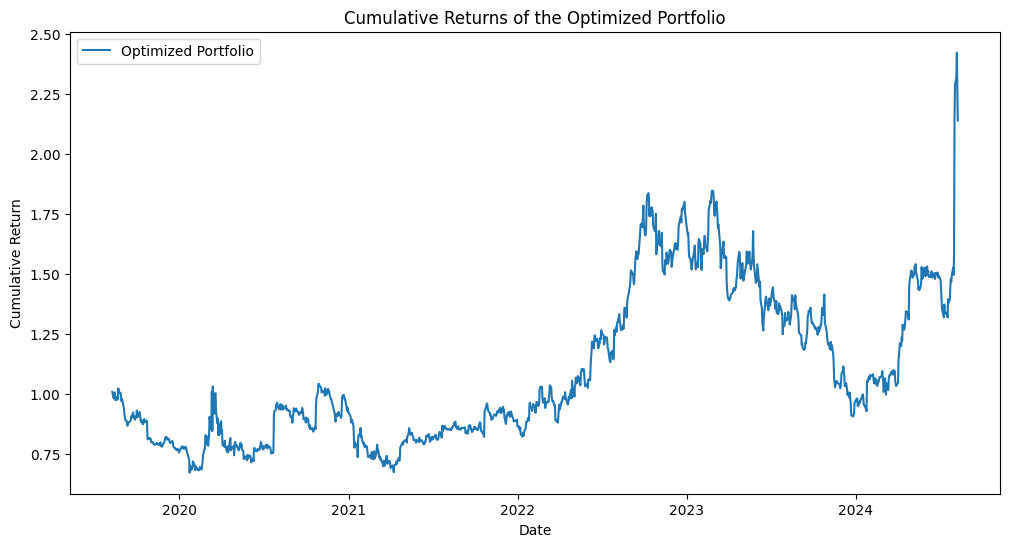

In [198]:
import pandas as pd
import numpy as np

# Create weights as a pandas Series
weights = pd.Series({
    'INTC': 9.999982e-01,
    'TSM': 4.368326e-07,
    'AVGO': 3.640058e-07,
    'AMD': 3.619575e-07,
    'NVDA': 2.596028e-07,
    'QCOM': 2.583993e-07,
    'TXN': 9.182685e-08,
    'ADI': 3.754265e-08
})

# Ensure that the order of weights matches the columns in returns_df
# Check if weights is already a pandas Series
if not isinstance(weights, pd.Series):
    weights = pd.Series(weights)

# Align the weights with the columns in returns_df
weights = weights.reindex(returns_df.columns)

# Calculate the portfolio's daily returns
portfolio_returns = (returns_df * weights).sum(axis=1)

# Calculate cumulative returns
cumulative_returns = (1 + portfolio_returns).cumprod()

# Display the results
print("Portfolio Returns:")
print(portfolio_returns.head())

print("\nCumulative Returns:")
print(cumulative_returns.head())

# Plot the cumulative returns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Optimized Portfolio')
plt.title('Cumulative Returns of the Optimized Portfolio')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()